# library required

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline  
import nltk
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer, PorterStemmer
from wordcloud import WordCloud, STOPWORDS
from textblob import TextBlob


In [3]:
import pandas as pd
import datetime
import re
import numpy as np
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.parsing.preprocessing import STOPWORDS


import nltk
from nltk.stem.porter import *
nltk.download('wordnet')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])
from nltk.stem import WordNetLemmatizer, SnowballStemmer

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)


[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/niloofar/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Explatory Analysis

In [4]:
df=pd.read_csv("./Downloads/Hotel_Reviews.csv")

# total number of hotels:

len(set(df.Hotel_Name))
df.Hotel_Name.value_counts()

#change the format of time to datetime

df['Review_Date']=pd.to_datetime(df['Review_Date'], format='%m/%d/%Y')

In [151]:
#Selecting one sample hotel with highest number of review
df1=df[df.Hotel_Name=="Britannia International Hotel Canary Wharf"]

df1.index = range(df1.shape[0])

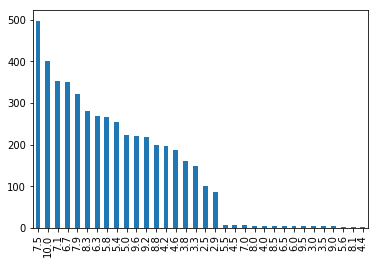

In [6]:
df1['Reviewer_Score'].value_counts().plot(kind='bar')

# Data pre-processing for textual variables

In [30]:
import pandas as pd
data_text = pd.DataFrame(df1['Positive_Review'])
data_text['Neg'] = df1['Negative_Review']
data_text['index'] = data_text.index
data_text.columns=['pos','neg','index']
data_text['pos']=["  " if x == 'No Positive' else x for x in data_text['pos']]
data_text['neg']=["  " if x == 'No Negative' else x for x in data_text['neg']]
# data_text['review']=data_text['pos']+data_text['neg']
# df=data_text['review']

In [31]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations


In [103]:
docp=list(sent_to_words(data_text['pos']))
docn=list(sent_to_words(data_text['neg']))


# Functions

In [36]:
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [172]:
def data_polish(texts):
    pre_1 = remove_stopwords(texts)
    pre_2= make_bigrams(pre_1)

    nlp = spacy.load('en', disable=['parser', 'ner'])
    pre_3 = lemmatization(pre_2, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
    return(pre_3)

In [ ]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
#         model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model =gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics,
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [61]:
def format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=df):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)




In [130]:
pre_docn=list(data_text['neg'])
pre_docp=list(data_text['pos'])



# In this function, the dominant topic of each review column for specific date is defined

In [152]:
def process(doc,pre_doc,time_table):
    bigram = gensim.models.Phrases(doc, min_count=5, threshold=100) # higher threshold fewer phrases.
    trigram = gensim.models.Phrases(bigram[doc], threshold=100)
    bigram_mod = gensim.models.phrases.Phraser(bigram)
#     trigram_mod = gensim.models.phrases.Phraser(trigram)
    data_words_nostops = remove_stopwords(doc)
    data_words_bigrams = make_bigrams(data_words_nostops)

    nlp = spacy.load('en', disable=['parser', 'ner'])
    data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
    id2word = corpora.Dictionary(data_lemmatized)
    texts = data_lemmatized
    corpus = [id2word.doc2bow(text) for text in texts]
#     lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
#                                            id2word=id2word,
#                                            num_topics=num_topic, 
#                                            random_state=100,
#                                            update_every=1,
#                                            chunksize=100,
#                                            passes=10,
#                                            alpha='auto',
#                                            per_word_topics=True)
    
    model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=20, step=1)
    opt=coherence_values.index(max(coherence_values))
    optimal_model=model_list[opt]
    
    df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=pre_doc)

    # Format
    df_dominant_topic = df_topic_sents_keywords.reset_index()
    df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
    df_dominant_topic=df_dominant_topic.merge(time_table, left_index=True, right_index=True)

    return(df_dominant_topic)




    

In [ ]:
negative_topics=process(docn,pre_docn,df1['Review_Date'])

In [ ]:
positive_topics=process(docp,pre_docp,df1['Review_Date'])

# Sentiment Analysis of Each Review

In [184]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyser = SentimentIntensityAnalyzer()

In [205]:
def sentiment_analyzer_scores(sentence):
    score = analyser.polarity_scores(sentence)
#     print("{:-<40} {}".format(sentence, str(score)))
    return("{}".format( str(score)))

In [206]:
aa=[sentiment_analyzer_scores(i) for i in pre_docn]

In [217]:
import ast

sent_score=[ast.literal_eval(i) for i in aa]
SC=pd.DataFrame(sent_score)

In [221]:
SC

,compound,neg,neu,pos
0,-0.0772,0.100,0.809,0.091
1,0.0000,0.000,1.000,0.000
2,-0.6613,0.201,0.740,0.058
3,-0.9578,0.238,0.762,0.000
4,0.4939,0.088,0.758,0.154
5,0.1265,0.041,0.909,0.050
6,-0.6335,0.064,0.897,0.038
7,-0.2006,0.100,0.818,0.082
8,-0.7517,0.110,0.890,0.000
9,0.2263,0.174,0.599,0.228


# Guided LDA

In [ ]:
text=pre_docn

In [154]:
from sklearn.feature_extraction.text import CountVectorizer


In [176]:
token_vectorizer = CountVectorizer(tokenizer = data_polish, min_df=10, stop_words=stop_words, ngram_range=(1, 3))

In [183]:
X = token_vectorizer.fit_transform(pre_docn)

TypeError: unhashable type: 'list'

In [157]:
cv = CountVectorizer(binary=True)
cv.fit(pre_docn)
X = cv.transform(pre_docn)

In [ ]:
min_df=10, stop_words=stop_words, ngram_range=(1, 4))

In [ ]:
token_vectorizer = CountVectorizer(tokenizer = reflection_tokenizer, min_df=10, stop_words=stop_words, ngram_range=(1, 4))

In [158]:
seed_topic_list={'staff':0,'location':1,'clean':2,'neutral':3,'breakfast':4,'bar':4,'value':5,'price':5,'money':5,'spa':6,'jacuzzi':6,'food':4,
 'restaurant':4,'friendly':0,'wharf':1,'canary':1,'cleanliness':2,'room':7,'bed':7,'bathroom':7,'balcony':7, 'gym':6,'swimming_pool':6,}


In [159]:
import guidedlda

model = guidedlda.GuidedLDA(n_topics=7, n_iter=100, random_state=7, refresh=10)
seed_topics = {}
# for t_id, st in enumerate(seed_topic_list):
#     for word in st:
#         seed_topics[word2id[word]] = t_id
model.fit(X, seed_topics=seed_topic_list, seed_confidence=0.15)

/Users/niloofar/Downloads/GuidedLDA-master/guidedlda/utils.py:55: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if sparse and not np.issubdtype(doc_word.dtype, int):


In [169]:
n_top_words = 15
topic_word = model.topic_word_
for i, topic_dist in enumerate(topic_word):
        topic_words = np.array(docn)[np.argsort(topic_dist)][:-(n_top_words+1):-1]
        print('Topic {}: {}'.format(i, ' '.join(topic_words)))

IndexError: index 6385 is out of bounds for axis 0 with size 4789

In [171]:
len(pre_docn)

4789

In [167]:
docn

[['the',
  'car',
  'park',
  'was',
  'small',
  'and',
  'unpleasant',
  'people',
  'with',
  'mercedes',
  'and',
  'bmws',
  'took',
  'over',
  'spaces',
  'we',
  'were',
  'lucky',
  'to',
  'get',
  'space',
  'after',
  'driving',
  'around',
  'about',
  'times'],
 ['we',
  'weren',
  'told',
  'that',
  'the',
  'only',
  'spa',
  'facility',
  'open',
  'was',
  'the',
  'pool',
  'and',
  'the',
  'sauna',
  'but',
  'we',
  'had',
  'already',
  'paid',
  'and',
  'had',
  'to',
  'find',
  'out',
  'ourselves',
  'when',
  'entering',
  'the',
  'spa',
  'area'],
 ['asked',
  'how',
  'far',
  'the',
  'was',
  'and',
  'got',
  'told',
  'minute',
  'walk',
  'no',
  'no',
  'way',
  'it',
  'was',
  'trains',
  'away',
  'being',
  'on',
  'my',
  'own',
  'was',
  'not',
  'very',
  'happy',
  'other',
  'than',
  'that',
  'it',
  'was',
  'ok'],
 ['hot',
  'stuffy',
  'room',
  'air',
  'con',
  'not',
  'working',
  'properly',
  'filthy',
  'windows',
  'wallpape

In [34]:
bigram = gensim.models.Phrases(doc, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[doc], threshold=100)
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)


In [35]:
print(trigram[trigram_mod[doc[0]]])

['the', 'location', 'was', 'excellent', 'for', 'getting', 'to', 'the', 'the', 'car_park', 'was', 'small', 'and', 'unpleasant', 'people', 'with', 'mercedes', 'and', 'bmws', 'took', 'over', 'spaces', 'we', 'were', 'lucky', 'to', 'get', 'space', 'after', 'driving', 'around', 'about', 'times']


# Lemmitize and stemming option (1)

In [37]:
data_words_nostops = remove_stopwords(doc)
data_words_bigrams = make_bigrams(data_words_nostops)

nlp = spacy.load('en', disable=['parser', 'ner'])
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
id2word = corpora.Dictionary(data_lemmatized)
texts = data_lemmatized


In [38]:
corpus = [id2word.doc2bow(text) for text in texts]
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]


[[('bmws', 1),
  ('drive', 1),
  ('excellent', 1),
  ('get', 2),
  ('location', 1),
  ('lucky', 1),
  ('mercede', 1),
  ('people', 1),
  ('small', 1),
  ('space', 2),
  ('take', 1),
  ('time', 1),
  ('unpleasant', 1)]]

In [52]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=10, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [53]:
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -7.485546078290323

Coherence Score:  0.46344209349528703


In [54]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

/usr/local/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
8      0.394652 -0.231035       1        1  42.537697
1      0.231889  0.356478       2        1  17.403334
5      0.002728 -0.012675       3        1  11.864248
2     -0.033503 -0.039759       4        1   9.833815
6     -0.079105 -0.015210       5        1   6.600883
9     -0.082834 -0.010145       6        1   4.329391
4     -0.104451 -0.011020       7        1   2.830802
0     -0.108930 -0.011576       8        1   2.230398
3     -0.110304 -0.012160       9        1   1.606170
7     -0.110144 -0.012898      10        1   0.763269, topic_info=     Category         Freq         Term        Total  loglift  logprob
67    Default  4234.000000         room  4234.000000  30.0000  30.0000
41    Default  1307.000000          bed  1307.000000  29.0000  29.0000
4     Default  2728.000000     location  2728.000000  28.0000  28.0000
102   Default  2223.000000        staff  2223.000000  27.0000  27.0000
25    Default   587.000000          pay   587.000000  26.0000  26.0000
120   Default  1753.000000         good  1753.000000  25.0000  25.0000
264   Default   408.000000        value   408.000000  24.0000  24.0000
231   Default   721.000000         view   721.000000  23.0000  23.0000
122   Default  1507.000000        hotel  1507.000000  22.0000  22.0000
119   Default   489.000000         free   489.000000  21.0000  21.0000
253   Default   335.000000        money   335.000000  20.0000  20.0000
105   Default   449.000000         wifi   449.000000  19.0000  19.0000
75    Default   603.000000       window   603.000000  18.0000  18.0000
195   Default   467.000000        night   467.000000  17.0000  17.0000
146   Default   422.000000        close   422.000000  16.0000  16.0000
3     Default   511.000000          get   511.000000  15.0000  15.0000
81    Default  1045.000000    breakfast  1045.000000  14.0000  14.0000
510   Default   469.000000  comfortable   469.000000  13.0000  13.0000
196   Default   376.000000        noisy   376.000000  12.0000  12.0000
313   Default   925.000000        great   925.000000  11.0000  11.0000
212   Default   320.000000      parking   320.000000  10.0000  10.0000
314   Default   246.000000         lift   246.000000   9.0000   9.0000
463   Default   307.000000    expensive   307.000000   8.0000   8.0000
110   Default   237.000000       charge   237.000000   7.0000   7.0000
83    Default   806.000000        clean   806.000000   6.0000   6.0000
255   Default   196.000000        noise   196.000000   5.0000   5.0000
40    Default   338.000000     bathroom   338.000000   4.0000   4.0000
211   Default   719.000000         nice   719.000000   3.0000   3.0000
14    Default   237.000000         area   237.000000   2.0000   2.0000
140   Default   316.000000      upgrade   316.000000   1.0000   1.0000
...       ...          ...          ...          ...      ...      ...
436   Topic10    31.320278      provide    33.057671   4.8213  -2.9909
855   Topic10    30.228312        thank    31.965557   4.8194  -3.0264
106   Topic10    19.677006      working    21.414259   4.7907  -3.4557
546   Topic10    19.281500     interior    21.018736   4.7890  -3.4760
428   Topic10     8.784185       bother    10.521882   4.6948  -4.2622
1794  Topic10     8.322927       heater    10.060168   4.6857  -4.3161
1632  Topic10     8.091139        email     9.828386   4.6808  -4.3444
3021  Topic10     7.116907      central     8.854095   4.6569  -4.4727
1799  Topic10     6.838714      promise     8.576720   4.6489  -4.5126
2657  Topic10     6.278024   disappoint     8.015932   4.6309  -4.5981
1422  Topic10     5.331000         wife     7.068392   4.5932  -4.7616
438   Topic10     4.086607     sandwich     5.823924   4.5211  -5.0274
3023  Topic10     4.044384      deliver     5.781572   4.5180  -5.0378
431   Topic10     2.998041       listen     4.735955   4.4181  -5.3372
2825  Topic10     3.001519         duty    

In [ ]:
# Show Topics
pprint(lda_model.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

# Topics

In [56]:
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.038*"air_conditione" + 0.028*"high" + 0.026*"indian_restaurant" + 0.018*"scruffy" + 0.017*"ambience" + 0.016*"pretty" + 0.015*"site" + 0.015*"bite" + 0.014*"temperature_control" + 0.013*"stuff"
Topic: 1 
Words: 0.265*"room" + 0.092*"bed" + 0.051*"view" + 0.042*"window" + 0.033*"comfortable" + 0.024*"bathroom" + 0.022*"upgrade" + 0.021*"dirty" + 0.017*"uncomfortable" + 0.017*"hot"
Topic: 2 
Words: 0.061*"free" + 0.056*"wifi" + 0.052*"close" + 0.029*"area" + 0.026*"carpet" + 0.023*"quality" + 0.020*"furniture" + 0.019*"refurbishment" + 0.016*"building" + 0.014*"toilet"
Topic: 3 
Words: 0.031*"handy" + 0.029*"suite" + 0.025*"situate" + 0.022*"limited" + 0.020*"be" + 0.019*"corridor" + 0.014*"house" + 0.014*"entrance" + 0.013*"twice" + 0.012*"fantastic"
Topic: 4 
Words: 0.049*"run" + 0.043*"perfect" + 0.043*"not" + 0.026*"welcome" + 0.024*"ideal" + 0.023*"arena" + 0.022*"do" + 0.021*"decorate" + 0.020*"warm" + 0.020*"fault"
Topic: 5 
Words: 0.048*"night" + 0.046*"get" + 

In [58]:
# Show Topics
pprint(lda_model.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(0,
  [('air_conditione', 0.03793445),
   ('high', 0.027704703),
   ('indian_restaurant', 0.025543869),
   ('scruffy', 0.017696856),
   ('ambience', 0.01677485),
   ('pretty', 0.016442861),
   ('site', 0.015025789),
   ('bite', 0.0149380425),
   ('temperature_control', 0.014462268),
   ('stuff', 0.013274346)]),
 (1,
  [('room', 0.26489553),
   ('bed', 0.091857485),
   ('view', 0.050618615),
   ('window', 0.04234006),
   ('comfortable', 0.03289616),
   ('bathroom', 0.023730857),
   ('upgrade', 0.022152765),
   ('dirty', 0.020572387),
   ('uncomfortable', 0.017340623),
   ('hot', 0.017138321)]),
 (2,
  [('free', 0.060771212),
   ('wifi', 0.0557781),
   ('close', 0.052411918),
   ('area', 0.029082995),
   ('carpet', 0.02552328),
   ('quality', 0.022576524),
   ('furniture', 0.019729314),
   ('refurbishment', 0.018979985),
   ('building', 0.015888544),
   ('toilet', 0.01390028)]),
 (3,
  [('handy', 0.03135369),
   ('suite', 0.029404791),
   ('situate', 0.024911162),
   ('limited', 0.02176

In [82]:
sent_topics_df = pd.DataFrame()
ldamodel=optimal_model
    # Get main topic in each document
for i, row_list in enumerate(ldamodel[corpus]):
    row = row_list[0] if ldamodel.per_word_topics else row_list            
    # print(row)
    row = sorted(row, key=lambda x: (x[1]), reverse=True)


In [98]:
sent_topics_df = pd.DataFrame()

# Get main topic in each document
for i, row_list in enumerate(ldamodel[corpus]):
    row = row_list[0] if ldamodel.per_word_topics else row_list            
    # print(row)
    row = sorted(row, key=lambda x: (x[1]), reverse=True)
    # Get the Dominant topic, Perc Contribution and Keywords for each document




In [101]:
row=pd.DataFrame(row)
row.columns=['topic_num', 'prop_topic']
row

,topic_num,prop_topic
0,2,0.357338
1,1,0.230162
2,4,0.126615
3,3,0.111627
4,5,0.099909
5,0,0.074350


In [119]:
# Select the model and print the topics
optimal_model = model_list[4]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=5))

# What is the Dominant topic and its percentage contribution in each document

def format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=doc):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
           row = row_list[0] if ldamodel.per_word_topics else row_list            
          # print(row)
           row = sorted(row, key=lambda x: (x[1]), reverse=True)
          # Get the Dominant topic, Perc Contribution and Keywords for each document
           for j, (topic_num, prop_topic) in enumerate(row):
                if j == 0:  # => dominant topic
                    wp = ldamodel.show_topic(topic_num)
                    topic_keywords = ", ".join([word for word, prop in wp])
                    sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
                else:
                    break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)





[(0,
  '0.027*"slow" + 0.022*"office" + 0.017*"temperature" + 0.014*"order" + '
  '0.013*"efficient"'),
 (1,
  '0.097*"bed" + 0.073*"room" + 0.045*"window" + 0.027*"work" + '
  '0.025*"bathroom"'),
 (2,
  '0.082*"room" + 0.072*"location" + 0.047*"good" + 0.040*"hotel" + '
  '0.037*"staff"'),
 (3,
  '0.077*"nothing" + 0.048*"excellent" + 0.046*"food" + 0.043*"staff" + '
  '0.038*"helpful"'),
 (4,
  '0.058*"service" + 0.052*"poor" + 0.048*"staff" + 0.038*"check" + '
  '0.026*"rude"'),
 (5,
  '0.048*"stay" + 0.042*"get" + 0.037*"night" + 0.029*"noisy" + 0.028*"would"')]


In [120]:

df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=list(data_text['review']))

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)




,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,2.0,0.3739,"room, location, good, hotel, staff, breakfast,...",The location was excellent for getting to the...
1,1,2.0,0.3958,"room, location, good, hotel, staff, breakfast,...",The house keeping lady made my boyfriends day...
2,2,2.0,0.4037,"room, location, good, hotel, staff, breakfast,...",I asked how far the O2 was and got told a 7...
3,3,2.0,0.2854,"room, location, good, hotel, staff, breakfast,...",The bed was OK Hot stuffy room air con not w...
4,4,2.0,0.5524,"room, location, good, hotel, staff, breakfast,...",The Receptionists and Cleaners are very polit...
5,5,2.0,0.6908,"room, location, good, hotel, staff, breakfast,...",My daughter and I were upgraded free of charg...
6,6,2.0,0.5802,"room, location, good, hotel, staff, breakfast,...",Could control the room temperature with the A...
7,7,2.0,0.3571,"room, location, good, hotel, staff, breakfast,...",Staff were friendly location good Room was f...
8,8,2.0,0.3292,"room, location, good, hotel, staff, breakfast,...",The bed was nice you could smoke in the room ...
9,9,2.0,0.4314,"room, location, good, hotel, staff, breakfast,...",Room overlooking Thames good bed and room Bre...


In [122]:
df_topic_sents_keywords['Dominant_Topic'].value_counts()



2.0    4725
1.0      29
5.0      27
4.0       5
0.0       2
3.0       1
Name: Dominant_Topic, dtype: int64

In [ ]:
df[0:10]

set(df_dominant_topic['Dominant_Topic'])

model_topics=model_topics[1:4]

df_dominant_topic['Text'][7]

df_dominant_topic['Keywords'][7]

df_topic_sents_keywords['Dominant_Topic'].value_counts()

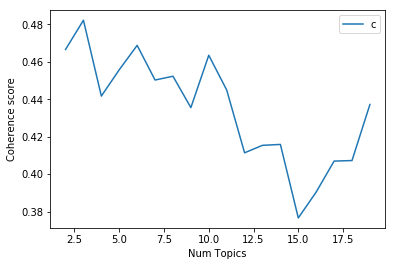

Num Topics = 2  has Coherence Value of 0.4666
Num Topics = 3  has Coherence Value of 0.4821
Num Topics = 4  has Coherence Value of 0.4417
Num Topics = 5  has Coherence Value of 0.4557
Num Topics = 6  has Coherence Value of 0.4687
Num Topics = 7  has Coherence Value of 0.4502
Num Topics = 8  has Coherence Value of 0.4522
Num Topics = 9  has Coherence Value of 0.4355
Num Topics = 10  has Coherence Value of 0.4634
Num Topics = 11  has Coherence Value of 0.4449
Num Topics = 12  has Coherence Value of 0.4114
Num Topics = 13  has Coherence Value of 0.4154
Num Topics = 14  has Coherence Value of 0.4158
Num Topics = 15  has Coherence Value of 0.3766
Num Topics = 16  has Coherence Value of 0.3904
Num Topics = 17  has Coherence Value of 0.4069
Num Topics = 18  has Coherence Value of 0.4072
Num Topics = 19  has Coherence Value of 0.4372


In [64]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
#         model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model =gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics,
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=20, step=1)


# Show graph
limit=20; start=2; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

